# *In situ* sampling design

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import glob
import plotly.express as px
from IPython.display import display
from collections import defaultdict

print('All libraries successfully imported!')
print(f'Pandas    : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')

All libraries successfully imported!
Pandas    : 1.1.5
GeoPandas : 0.9.0


## Set directory

In [2]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

in_situ_path = f'{work_path}IN_SITU/'

## Set parameters

In [3]:
site = 'NAMUR'
year = '2020'

field_classif_code = 'grp_1_nb'
field_classif_name = 'grp_1'

pix_best = 10
pix_ratio_threshold = 0.05

sample_ratio_hi = 0.25
sample_ratio_lo = 0.75

## Set filenames

In [4]:
in_situ_prepared_shp = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_prepared.shp'

in_situ_cal_shp = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_CAL.shp'
in_situ_val_shp = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_VAL.shp'

## Open *in situ* data prepared

In [5]:
gdf = gpd.read_file(in_situ_prepared_shp)

display(gdf.head())

,id,lc_nb,lc,grp_nb,grp,class_nb,class,sub_nb,sub,grp_1_nb,grp_1,grp_A_nb,grp_A,area,pix_count,geometry
0,4,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,1735,17,"MULTIPOLYGON (((630003.573 5594258.004, 630003..."
1,5,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,14331,146,"POLYGON ((636962.589 5595674.757, 636966.536 5..."
2,6,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,1768,18,"POLYGON ((635692.119 5593303.601, 635688.405 5..."
3,7,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,7828,79,"POLYGON ((627911.368 5595749.375, 627942.033 5..."
4,9,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,3197,39,"POLYGON ((633236.525 5596165.100, 633397.286 5..."


## Get "pixel ratio" for each polygons

Pixel ratio = number of 10m pixels belonging to specific crop type
divided by the total number of 10m pixels

$ pix\_ratio = \frac{crop\_pix}{total\_pix} $


> All polygons from a same class will have the same pixel ratio !

In [6]:
gdf['crop_pix'] = gdf.groupby(field_classif_code)['pix_count'].transform('sum')

gdf['pix_ratio'] = gdf['crop_pix'] / gdf['pix_count'].sum()

display(gdf.head())

,id,lc_nb,lc,grp_nb,grp,class_nb,class,sub_nb,sub,grp_1_nb,grp_1,grp_A_nb,grp_A,area,pix_count,geometry,crop_pix,pix_ratio
0,4,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,1735,17,"MULTIPOLYGON (((630003.573 5594258.004, 630003...",23889,0.222207
1,5,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,14331,146,"POLYGON ((636962.589 5595674.757, 636966.536 5...",23889,0.222207
2,6,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,1768,18,"POLYGON ((635692.119 5593303.601, 635688.405 5...",23889,0.222207
3,7,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,7828,79,"POLYGON ((627911.368 5595749.375, 627942.033 5...",23889,0.222207
4,9,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,Grassland and meadows,3,Grassland and meadows,3197,39,"POLYGON ((633236.525 5596165.100, 633397.286 5...",23889,0.222207


## Assign sampling design strategy for each polygons

The polygons that are selected for the classification are used either for the calibration of the classifier model or for the validation of the results. Even though the classification is run per-pixel, this split
needs to be done at the polygon-level to ensure a proper independent validation following international
standards.  
This split at the polygon-level is done into 3 steps:
- the smallest polygons are automatically NOT considered for the calibration and thus assigned to the
validation pool;
- for each class, the number of training pixels $crop\_target$ is defined considering the size of the class;
- calibration polygons are randomly selected to reach this $crop\_target$ value and the remaining
polygons are allocated to the validation.

### Strategy 1 — majority classes

By default, the majority classes are defined as those counting a number of 10m pixels corresponding to more
than 5% (`pix_ratio_threshold`) of the total number of pixels considering all classes to map.

Crop type belongs to strategy 1 if :

$pix\_ratio ≥ pix\_ratio\_threshold$

In this case, for each majority class, the number of training pixels $crop\_target$ will correspond to 25% of the number of pixels of the class (crop_pixels) :

$crop\_target = sample\_ratio\_hi \times crop\_pix$

### Strategy 2 — minority classes

The minor classes are defined as those counting a number of S2 pixels corresponding to less than 5% of the
total number of pixels considering all classes to map.
 
Crop type belongs to strategy 2 if :

$pix\_ratio < pix\_ratio\_threshold$

In this case, for each minor class, the number of training pixels $crop\_target$ will correspond to 75% of the number of pixels of the class :

$crop\_target = sample\_ratio\_lo \times crop\_pix$

In [7]:
# Assign sampling design strategy for each polygons
# -------------------------------------------------

gdf['strategy'] = np.where(gdf['pix_count'] < pix_best, 3,
                           np.where(gdf['pix_ratio'] >= pix_ratio_threshold, 1, 2))


# Build a table to summarize the strategy assign to each class
df = gdf[[field_classif_code,field_classif_name,'crop_pix','pix_ratio','strategy']].drop_duplicates()
df = df[df['strategy'] != 3].sort_values('pix_ratio', ascending=False)

display(df)


# Split polygons in training and validation datasets
# --------------------------------------------------

training_pixels = defaultdict(lambda: 0)
training_target = {}

cal_id_list = []
val_id_list = []

gdf_shuffle = gdf.sample(len(gdf), random_state=1)  # Shuffle geodataframe randomly

for i, row in gdf_shuffle.iterrows():

    id          = row['id']
    crop_code   = row[field_classif_code]
    crop_pix    = row['crop_pix']
    strategy    = row['strategy']
    pix_count   = row['pix_count']

    if strategy != 3:
        if strategy == 1:
            crop_target = sample_ratio_hi * crop_pix
            training_target[crop_code] = crop_target
        
        elif strategy == 2:
            crop_target = sample_ratio_lo * crop_pix
            training_target[crop_code] = crop_target

        pixels = training_pixels[crop_code]

        if pixels + pix_count <= crop_target:  # If below crop target, add polygons in training set
            training_pixels[crop_code] = pixels + pix_count  # Update number of training pixels by crop code
            purpose = 0  # training
        
        else:
            purpose = 1  # validation because "crop target" is reached
    else:
        purpose = 1  # validation because polygons do not contain enough pixels (= strategy 3)

    if purpose == 0:
        cal_id_list.append(id)
    else:
        val_id_list.append(id)


print(f'Number of polygons for training   : {len(cal_id_list)}')
print(f'Number of polygons for validation : {len(val_id_list)}')

cal_gdf = gdf[gdf['id'].isin(cal_id_list)]

val_gdf = gdf[gdf['id'].isin(val_id_list)]


,grp_1_nb,grp_1,crop_pix,pix_ratio,strategy
221,1111,Winter wheat,29633,0.275635,1
0,3,Grassland and meadows,23889,0.222207,1
295,1121,Maize,8667,0.080617,1
331,1811,Sugar beet,7400,0.068832,1
352,1152,Barley six-row,6659,0.061940,1
441,1511,Potatoes,6439,0.059893,1
376,1192,Other cereals,6117,0.056898,1
411,1771,Peas,3606,0.033542,2
502,69,Forest,3109,0.028919,2
403,1923,Flax hemp and other similar crops,2810,0.026138,2


Number of polygons for calibration : 205
Number of polygons for validation  : 332


### Get summary of the CAL/VAL splitting 

In [8]:
# Get number of pixels per class

pix_per_class_cal_df = cal_gdf.groupby([field_classif_code, field_classif_name])['pix_count'].agg('sum').to_frame().reset_index()
pix_per_class_cal_df = pix_per_class_cal_df.sort_values(by='pix_count', ascending=False)
pix_per_class_cal_df = pix_per_class_cal_df.rename(columns={"pix_count": "CAL_pix"})

pix_per_class_val_df = val_gdf.groupby([field_classif_code, field_classif_name])['pix_count'].agg('sum').to_frame().reset_index()
pix_per_class_val_df = pix_per_class_val_df.sort_values(by='pix_count', ascending=False)
pix_per_class_val_df = pix_per_class_val_df.rename(columns={"pix_count": "VAL_pix"})

# Get number of polygons per class

poly_per_class_cal_df = cal_gdf.groupby([field_classif_code, field_classif_name])[field_classif_code].agg('count').reset_index(name='poly_count')
poly_per_class_cal_df = poly_per_class_cal_df.sort_values(by='poly_count', ascending=False)
poly_per_class_cal_df = poly_per_class_cal_df.rename(columns={"poly_count": "CAL_poly"})

poly_per_class_val_df = val_gdf.groupby([field_classif_code, field_classif_name])[field_classif_code].agg('count').reset_index(name='poly_count')
poly_per_class_val_df = poly_per_class_val_df.sort_values(by='poly_count', ascending=False)
poly_per_class_val_df = poly_per_class_val_df.rename(columns={"poly_count": "VAL_poly"})


# Merge 2 previous dataframe in a single one
#pix_poly_per_class_df = pix_per_class_cal_df.merge(poly_per_class_df, on=[field_classif_code, field_classif_name], how="outer")


# Merge 4 previous dataframe in a single one
summary_df = pix_per_class_cal_df.merge(pix_per_class_val_df,on=[field_classif_code, field_classif_name]).merge(poly_per_class_cal_df,on=[field_classif_code, field_classif_name]).merge(poly_per_class_val_df,on=[field_classif_code, field_classif_name])

display(summary_df)


,grp_1_nb,grp_1,CAL_pix,VAL_pix,CAL_poly,VAL_poly
0,1111,Winter wheat,7403,22230,15,59
1,3,Grassland and meadows,5971,17918,60,161
2,1771,Peas,2454,1152,8,2
3,69,Forest,2296,813,28,7
4,1121,Maize,2132,6535,10,26
5,1923,Flax hemp and other similar crops,2059,751,5,3
6,1811,Sugar beet,1850,5550,4,17
7,1152,Barley six-row,1663,4996,8,12
8,1511,Potatoes,1577,4862,4,10
9,21,Fruits trees,1551,688,6,1


## Plot calibration and validation *in situ* data

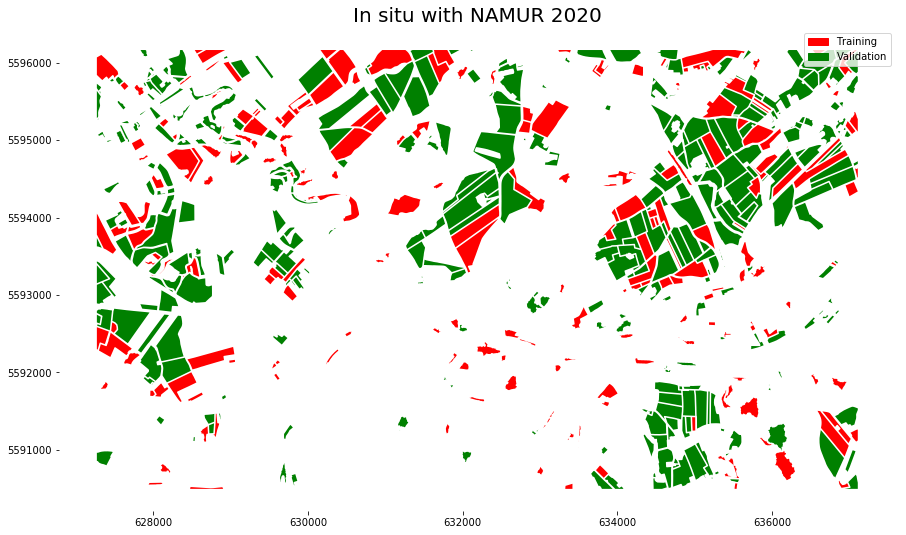

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

cal_gdf.plot(ax=ax,
            color='red')

val_gdf.plot(ax=ax,
            color='green')

ax.set_title(f'In situ with {site} {year}',fontsize=20)

cal_patch = mpatches.Patch(color='red', label='Training')
val_patch = mpatches.Patch(color='green', label='Validation')


plt.legend(handles=[cal_patch, val_patch])

plt.box(False)

## Write geodataframe into a shapefile

In [10]:
cal_gdf.to_file(in_situ_cal_shp)
val_gdf.to_file(in_situ_val_shp)

print(f'Two shapefiles have been created :\n {in_situ_cal_shp} \n {in_situ_val_shp}')

Two shapefiles have been created :
 /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_CAL.shp 
 /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_VAL.shp
